In [1]:
!pip install gymnasium pettingzoo matplotlib seaborn

In [2]:
import sys
gym_location = "/home/sid/Study/brainybytes/Learning_Dynamics/env/lib/python3.12/site-packages"
sys.path.append(gym_location)

In this Notebook, you have to implement both Independent Learners (which are basically Q-Learners, but since the setting is again stateless, the updates simplify since there is no discount factor and no next time step) and Joint-Action Learners (Claus & Boutilier, 1998) in some coordination games. The code for the Independent Learner is copied from the notebook from last week, which you can just use as is.

Implement code where it is asked (often as a comment).

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
from pettingzoo import ParallelEnv

In [4]:
class Qlearner:
    """A Q-learning agent"""

    def __init__(
        self,
        action_size,
        state_size,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995,
    ):
        self.action_size = action_size
        self.state_size = state_size

        # initialize the Q-table:
        self.qtable = np.zeros((self.state_size, self.action_size))

        # define learning rate:
        if learning_rate == 0.0:
            self.dynamic_lr = True
            self.action_counter = np.zeros((self.state_size, self.action_size))
        else:
            self.dynamic_lr = False
            self.learning_rate = learning_rate

        # discount factor:
        self.gamma = gamma

        # Exploration parameters:
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # tracking rewards/progress:
        self.rewards_this_episode = []  # during an episode, save every time step's reward
        self.episode_total_rewards = []  # each episode, sum the rewards, possibly with a discount factor
        self.average_episode_total_rewards = []  # the average (discounted) episode reward to indicate progress

        self.state_history = []
        self.action_history = []

    def reset_agent(self):
        self.qtable = np.zeros((self.state_size, self.action_size))

    def select_greedy(self, state):
        # np.argmax(self.qtable[state]) will select first entry if two or more Q-values are equal, but we want true randomness:
        print("qtable[state] and qtable[state].max", self.qtable[state], self.qtable[state].max())
        print("np.isclose", np.isclose(self.qtable[state], self.qtable[state].max()))
        return np.random.choice(np.flatnonzero(np.isclose(self.qtable[state], self.qtable[state].max())))

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            print("selecting random")
            action = random.randrange(self.action_size)
        else:
            print("selecting greedy")
            action = self.select_greedy(state)

        self.state_history.append(state)
        self.action_history.append(action)
        return action

    def update_epsilon(self):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)

    def update(self, state, action, new_state, reward, done, update_epsilon=True):
        if not self.dynamic_lr:
            lr = self.learning_rate
        else:
            self.action_counter[state, action] += 1
            lr = 1 / self.action_counter[state, action]

        # Q(s,a) <-- Q(s,a) + learning_rate [R + gamma * max_a' Q(s',a') - Q(s,a)]
        self.qtable[state, action] += lr * (reward + (not done) * self.gamma * np.max(self.qtable[new_state]) - self.qtable[state, action])

        self.rewards_this_episode.append(reward)

        if done:
            # track total reward:
            episode_reward = self._calculate_episode_reward(self.rewards_this_episode, discount=False)
            self.episode_total_rewards.append(episode_reward)

            k = len(self.average_episode_total_rewards) + 1  # amount of episodes that have passed
            self._calculate_average_episode_reward(k, episode_reward)

            if update_epsilon:
                self.update_epsilon()

            # reset the rewards for the next episode:
            self.rewards_this_episode = []

    def _calculate_episode_reward(self, rewards_this_episode, discount=False):
        if discount:
            return sum([self.gamma**i * reward for i, reward in enumerate(rewards_this_episode)])
        return sum(rewards_this_episode)

    def _calculate_average_episode_reward(self, k, episode_reward):
        if k > 1:  # running average is more efficient:
            average_episode_reward = (1 - 1 / k) * self.average_episode_total_rewards[-1] + episode_reward / k
        else:
            average_episode_reward = episode_reward
        self.average_episode_total_rewards.append(average_episode_reward)

    def print_rewards(self, episode, print_epsilon=True, print_q_table=True):
        print("Episode ", episode + 1)
        print("Total (discounted) reward of this episode: ", self.episode_total_rewards[episode])
        print("Average total reward over all episodes until now: ", self.average_episode_total_rewards[-1])

        print("Epsilon:", self.epsilon) if print_epsilon else None
        print("Q-table: ", self.qtable) if print_q_table else None


In [5]:
class JointActionLearner:
    """A joint action learner for matrix game environments."""
    
    def __init__(
        self,
        action_size,
        state_size,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995,
        opponent_action_size=2  # Added back explicitly
    ):
        self.action_size = action_size
        self.state_size = state_size
        self.opponent_action_size = opponent_action_size
        
        # Initialize Q-table with proper dimensions
        self.qtable = np.zeros((state_size, action_size, opponent_action_size))
        self.opponent_action_counts = np.ones(opponent_action_size)
        
        # Learning parameters
        if learning_rate == 0.0:
            self.dynamic_lr = True
            self.action_counter = np.zeros((state_size, action_size))
        else:
            self.dynamic_lr = False
            self.learning_rate = learning_rate
            
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Performance tracking
        self.rewards_this_episode = []
        self.episode_total_rewards = []
        self.average_episode_total_rewards = []
    
    def select_greedy(self, state):
        """Select action with highest expected value based on opponent model."""
        opponent_probs = self.opponent_action_counts / np.sum(self.opponent_action_counts)
        expected_values = np.sum(self.qtable[state] * opponent_probs, axis=1)
        return np.random.choice(np.flatnonzero(expected_values == expected_values.max()))
    
    def select_action(self, state):
        """Select action using epsilon-greedy strategy."""
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)
        return self.select_greedy(state)
    
    def update_opponent_distribution(self, opponent_action):
        """Update empirical distribution of opponent actions."""
        self.opponent_action_counts[opponent_action] += 1
    
    def update(self, state, action, new_state, reward, done):
        """Update Q-values based on reward and next state."""
        # Calculate learning rate
        if self.dynamic_lr:
            self.action_counter[state, action] += 1
            lr = 1.0 / self.action_counter[state, action]
        else:
            lr = self.learning_rate
            
        opponent_probs = self.opponent_action_counts / np.sum(self.opponent_action_counts)
        
        # Calculate future value
        if not done:
            expected_future_values = np.sum(self.qtable[new_state] * opponent_probs, axis=1)
            print("expected_future_values: ", expected_future_values)
            max_future_q = np.max(expected_future_values)
        else:
            max_future_q = 0
            
        # Update Q-table
        #print("lr * (reward + self.gamma * max_future_q)", lr * (reward + self.gamma * max_future_q))
        #print("self.qtable[state, action]", self.qtable[state, action])
        #print("lr * (reward + self.gamma * max_future_q - self.qtable[state, action])", lr * (reward + self.gamma * max_future_q - self.qtable[state, action]))
        
        self.qtable[state, action] = self.qtable[state, action] + \
            lr * (reward + self.gamma * max_future_q - self.qtable[state, action])
        
        # Track rewards and update epsilon
        self.rewards_this_episode.append(reward)
        
        if done:
            episode_reward = sum(self.rewards_this_episode)
            self.episode_total_rewards.append(episode_reward)
            
            k = len(self.episode_total_rewards)
            if k > 1:
                avg_reward = (1 - 1/k) * self.average_episode_total_rewards[-1] + episode_reward/k
            else:
                avg_reward = episode_reward
            self.average_episode_total_rewards.append(avg_reward)
            
            self.rewards_this_episode = []
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
    def print_rewards(self, episode, print_epsilon=True, print_q_table=True):
        print("Episode ", episode + 1)
        print("Total (discounted) reward of this episode: ", self.episode_total_rewards[episode])
        print("Average total reward over all episodes until now: ", self.average_episode_total_rewards[-1])
        print("Opponent action counts: ", self.opponent_action_counts)

        print("Epsilon:", self.epsilon) if print_epsilon else None
        print("Q-table: ", self.qtable) if print_q_table else None


In [6]:
class MatrixGame(ParallelEnv):
    metadata = {'render_modes': ['human']}

    def __init__(self, reward_matrix):
        self.agents = ["player_0", "player_1"]
        self.possible_agents = self.agents[:]
        self.reward_matrix = reward_matrix

        self.action_spaces = {agent: spaces.Discrete(reward_matrix.shape[0]) for agent in self.agents}
        self.observation_spaces = {agent: spaces.Discrete(1) for agent in self.agents}

    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0.0 for agent in self.agents}
        self.dones = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.state = None  # Stateless environment

        return {agent: 0 for agent in self.agents}  # Observations are dummy since the environment is stateless

    def step(self, actions):
        if not self.agents:
            return

        # Extract actions
        action_0 = actions[self.agents[0]]
        action_1 = actions[self.agents[1]]

        # Get rewards from the reward matrix
        reward_0, reward_1 = self.reward_matrix[action_0, action_1]

        # Update rewards
        self.rewards = {self.agents[0]: reward_0, self.agents[1]: reward_1}

        # Since this is a one-shot game, mark agents as done
        self.dones = {agent: True for agent in self.agents}
        self.truncateds = {agent: False for agent in self.agents}

        # No additional info in this case
        self.infos = {agent: {} for agent in self.agents}

        # Observations are dummy since the environment is stateless
        observations = {agent: 0 for agent in self.agents}

        return observations, self.rewards, self.dones, self.truncateds, self.infos

    def render(self):
        pass

    def close(self):
        pass

In [7]:
# Run the Independent Learner experiment:

# Define the Hill-Climbing game reward matrix
ASYMMETRIC_COORDINATION_GAME = np.array([[(11, 11), (0, 0)],  # Both pick action 0 -> high reward
                                        [(0, 0), (6, 6)]])   # Both pick action 1 -> moderate reward

# Define the optimal joint action (0, 0) is optimal in the Hill-Climbing game
optimal_joint_action = (0, 0)

# Number of trial runs
num_trials = 100
num_episodes = 1000

# Store the probability of optimal joint action for each episode, averaged across trials
optimal_action_probs_il = np.zeros(num_episodes)

for trial in range(num_trials):
    # Initialize environment and agents for Independent Learners (ILs)
    env = MatrixGame(reward_matrix=ASYMMETRIC_COORDINATION_GAME)

    agent_0_il = Qlearner(
        action_size=2,
        state_size=1,
        learning_rate=0.0,  # dynamic learning rate
        gamma=0.95,  # does not matter
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    agent_1_il = Qlearner(
        action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    # Keep track of the number of optimal actions for each episode
    optimal_actions_il = np.zeros(num_episodes)

    for episode in range(num_episodes):
        observations = env.reset()
        state = 0  # Single state in the Hill-Climbing game

        done = False

        # Agents take actions
        print(agent_0_il.qtable)
        action_0_il = agent_0_il.select_action(state)
        action_1_il = agent_1_il.select_action(state)

        actions = {"player_0": action_0_il, "player_1": action_1_il}

        # Step in the environment
        observations, rewards, dones, _, infos = env.step(actions)

        # Check if the agents selected the optimal joint action
        if (action_0_il, action_1_il) == optimal_joint_action:
            optimal_actions_il[episode] += 1

        # Update Q-tables
        agent_0_il.update(state, action_0_il, state, rewards["player_0"], dones["player_0"])
        agent_1_il.update(state, action_1_il, state, rewards["player_1"], dones["player_1"])
        
        #agent_0_il.print_rewards(episode)

    # Calculate the probability of optimal joint action over episodes for this trial
    optimal_action_probs_il += optimal_actions_il / num_trials  # Averaging across trials

[[0. 0.]]
selecting random
selecting random
[[0. 0.]]
selecting random
selecting random
[[11.  0.]]
selecting random
selecting random
[[11.  3.]]
selecting random
selecting random
[[11.  3.]]
selecting random
selecting random
[[11.  4.]]
selecting random
selecting random
[[11.  4.]]
selecting random
selecting random
[[11.  3.]]
selecting random
selecting random
[[11.   3.6]]
selecting random
selecting random
[[8.25 3.6 ]]
selecting random
selecting random
[[8.25 3.  ]]
selecting random
selecting random
[[8.25       3.42857143]]
selecting random
selecting random
[[8.8        3.42857143]]
selecting random
selecting greedy
qtable[state] and qtable[state].max [6.28571429 4.8       ] 6.285714285714286
np.isclose [ True False]
[[9.16666667 3.42857143]]
selecting random
selecting random
[[9.16666667 3.        ]]
selecting random
selecting random
[[9.16666667 3.33333333]]
selecting greedy
qtable[state] and qtable[state].max [9.16666667 3.33333333] 9.166666666666668
np.isclose [ True False]
sel

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



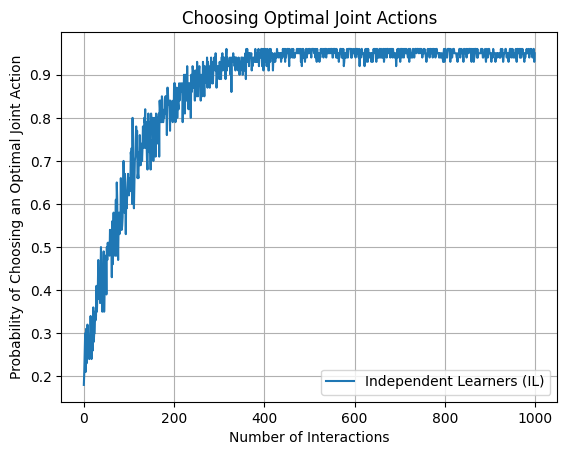

In [8]:
# Plot the results
plt.plot(optimal_action_probs_il, label='Independent Learners (IL)')
plt.xlabel('Number of Interactions')
plt.ylabel('Probability of Choosing an Optimal Joint Action')
plt.title('Choosing Optimal Joint Actions')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
optimal_action_probs_jal = np.zeros(num_episodes)

# Run multiple trial runs
for trial in range(num_trials):
    # Initialize environment and agents for Joint Action Learners (JALs)
    env = MatrixGame(reward_matrix=ASYMMETRIC_COORDINATION_GAME)

    # Initialize JAL agents instead of IL agents
    agent_0_jal = JointActionLearner(
        action_size=2,
        state_size=1,
        learning_rate=0.0,  # dynamic learning rate
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    agent_1_jal = JointActionLearner(
        action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    # Keep track of the number of optimal actions for each episode
    optimal_actions_jal = np.zeros(num_episodes)

    for episode in range(num_episodes):
        observations = env.reset()
        state = 0  # Single state in the Hill-Climbing game

        done = False

        # Agents take actions
        action_0_jal = agent_0_jal.select_action(state)
        action_1_jal = agent_1_jal.select_action(state)

        actions = {"player_0": action_0_jal, "player_1": action_1_jal}

        # Step in the environment
        observations, rewards, dones, _, infos = env.step(actions)

        # Check if the agents selected the optimal joint action
        if (action_0_jal, action_1_jal) == optimal_joint_action:
            optimal_actions_jal[episode] += 1
            
        # In your training loop:
        # Update Q-tables and opponent distributions
        agent_0_jal.update(state, action_0_jal, state, rewards["player_0"], dones["player_0"])
        agent_1_jal.update(state, action_1_jal, state, rewards["player_1"], dones["player_1"])

        # Update beliefs about opponent strategies
        agent_0_jal.update_opponent_distribution(action_1_jal)
        agent_1_jal.update_opponent_distribution(action_0_jal)
        
        #print("*"*20)
        

    # Calculate the probability of optimal joint action over episodes for this trial
    optimal_action_probs_jal += optimal_actions_jal / num_trials  # Averaging across trials

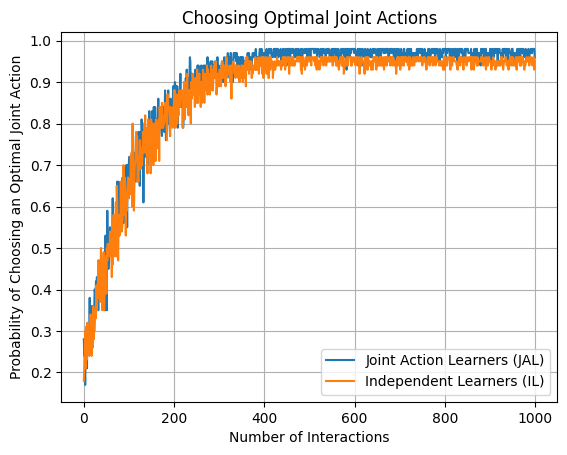

In [10]:
# Plot the results with both JAL and IL
plt.plot(optimal_action_probs_jal, label='Joint Action Learners (JAL)')
plt.plot(optimal_action_probs_il, label='Independent Learners (IL)')
plt.xlabel('Number of Interactions')
plt.ylabel('Probability of Choosing an Optimal Joint Action')
plt.title('Choosing Optimal Joint Actions')
plt.legend()
plt.grid(True)
plt.show()

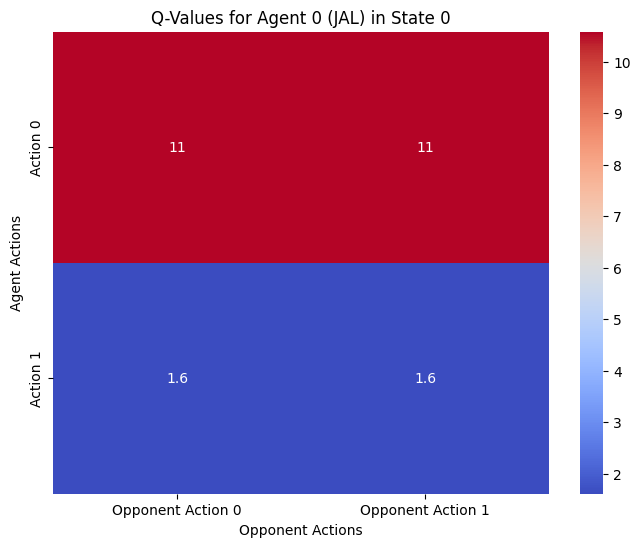

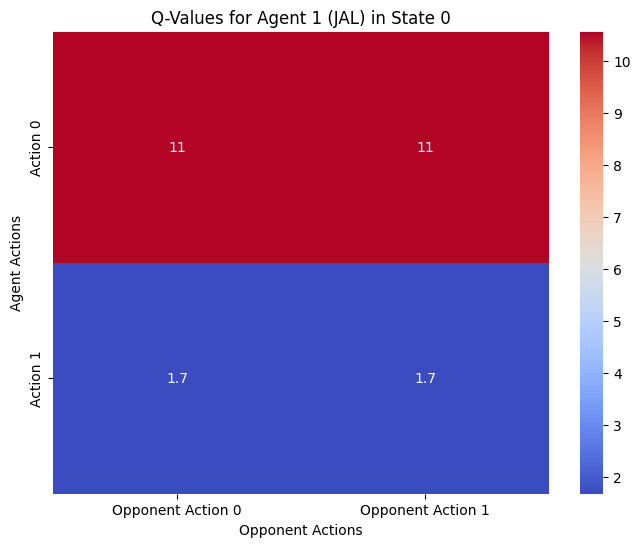

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_q_values_heatmap(agent, agent_name):
    for state in range(agent.state_size):
        plt.figure(figsize=(8, 6))
        q_values = agent.qtable[state]  # Get the Q-values for this state
        sns.heatmap(q_values, annot=True, cmap="coolwarm", cbar=True, xticklabels=[f"Opponent Action {i}" for i in range(agent.opponent_action_size)], yticklabels=[f"Action {i}" for i in range(agent.action_size)])
        plt.title(f"Q-Values for {agent_name} in State {state}")
        plt.xlabel("Opponent Actions")
        plt.ylabel("Agent Actions")
        plt.show()

# Example: Plot heatmaps for both JAL agents
plot_q_values_heatmap(agent_0_jal, "Agent 0 (JAL)")
plot_q_values_heatmap(agent_1_jal, "Agent 1 (JAL)")

Now, do the same for a fully symmetric coordination game as above. Also plot your results and explain them.

In [12]:
# Both coordinated actions (0, 0) and (1, 1) give reward 10
COORDINATION_MATRIX = np.array([[(10, 10), (0, 0)],  # (0, 0) is optimal
                                  [(0, 0), (10, 10)]])  # (1, 1) is also optimal

In [13]:
# Number of trial runs
num_trials = 100
num_episodes = 1000

# There are two optimal joint actions in the symmetric game: (0,0) and (1,1)
optimal_joint_actions = [(0, 0), (1, 1)]

# Store the probability of optimal joint actions for each episode, averaged across trials
optimal_action_probs_il_sym = np.zeros(num_episodes)
optimal_action_probs_jal_sym = np.zeros(num_episodes)

# Independent Learners experiment
for trial in range(num_trials):
    # Initialize environment and agents for Independent Learners (ILs)
    env = MatrixGame(reward_matrix=COORDINATION_MATRIX)

    agent_0_il = Qlearner(
        action_size=2,
        state_size=1,
        learning_rate=0.0,  # dynamic learning rate
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    agent_1_il = Qlearner(
        action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    # Keep track of the number of optimal actions for each episode
    optimal_actions_il = np.zeros(num_episodes)

    for episode in range(num_episodes):
        observations = env.reset()
        state = 0  # Single state

        # Agents take actions
        action_0_il = agent_0_il.select_action(state)
        action_1_il = agent_1_il.select_action(state)

        actions = {"player_0": action_0_il, "player_1": action_1_il}

        # Step in the environment
        observations, rewards, dones, _, infos = env.step(actions)

        # Check if the agents selected any optimal joint action
        if (action_0_il, action_1_il) in optimal_joint_actions:
            optimal_actions_il[episode] += 1

        # Update Q-tables
        agent_0_il.update(state, action_0_il, state, rewards["player_0"], dones["player_0"])
        agent_1_il.update(state, action_1_il, state, rewards["player_1"], dones["player_1"])

    optimal_action_probs_il_sym += optimal_actions_il / num_trials

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
# Joint Action Learners experiment
for trial in range(num_trials):
    # Initialize environment and agents for Joint Action Learners (JALs)
    env = MatrixGame(reward_matrix=COORDINATION_MATRIX)

    agent_0_jal = JointActionLearner(
        action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    agent_1_jal = JointActionLearner(
        action_size=2,
        state_size=1,
        learning_rate=0.0,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.99
    )

    optimal_actions_jal = np.zeros(num_episodes)

    for episode in range(num_episodes):
        observations = env.reset()
        state = 0

        action_0_jal = agent_0_jal.select_action(state)
        action_1_jal = agent_1_jal.select_action(state)

        actions = {"player_0": action_0_jal, "player_1": action_1_jal}

        observations, rewards, dones, _, infos = env.step(actions)

        if (action_0_jal, action_1_jal) in optimal_joint_actions:
            optimal_actions_jal[episode] += 1

        # Update Q-tables and opponent distributions
        agent_0_jal.update(state, action_0_jal, state, rewards["player_0"], dones["player_0"])
        agent_1_jal.update(state, action_1_jal, state, rewards["player_1"], dones["player_1"])

        # Update beliefs about opponent strategies
        agent_0_jal.update_opponent_distribution(action_1_jal)
        agent_1_jal.update_opponent_distribution(action_0_jal)

    optimal_action_probs_jal_sym += optimal_actions_jal / num_trials


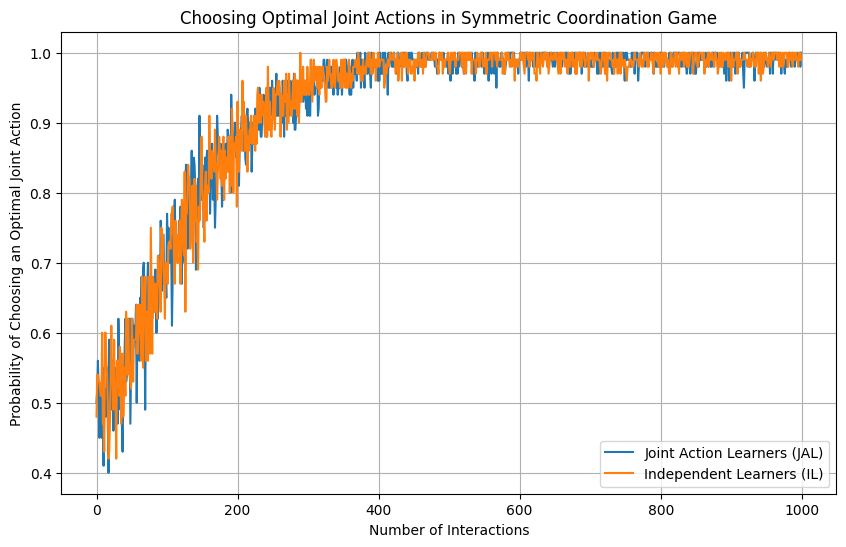

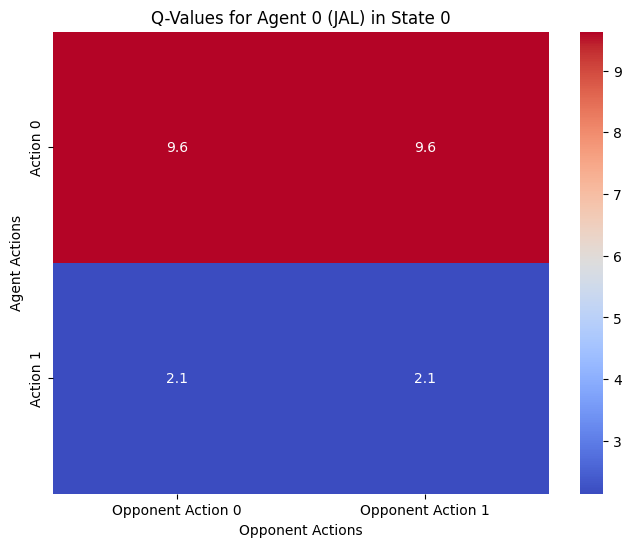

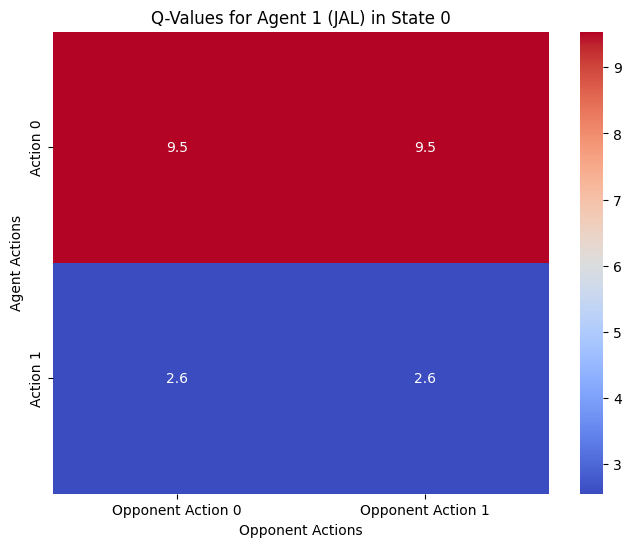

In [15]:
# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(optimal_action_probs_jal_sym, label='Joint Action Learners (JAL)')
plt.plot(optimal_action_probs_il_sym, label='Independent Learners (IL)')
plt.xlabel('Number of Interactions')
plt.ylabel('Probability of Choosing an Optimal Joint Action')
plt.title('Choosing Optimal Joint Actions in Symmetric Coordination Game')
plt.legend()
plt.grid(True)
plt.show()

# Plot Q-value heatmaps for final JAL agents
def plot_q_values_heatmap(agent, agent_name):
    for state in range(agent.state_size):
        plt.figure(figsize=(8, 6))
        q_values = agent.qtable[state]
        sns.heatmap(q_values, annot=True, cmap="coolwarm", cbar=True, 
                   xticklabels=[f"Opponent Action {i}" for i in range(agent.opponent_action_size)], 
                   yticklabels=[f"Action {i}" for i in range(agent.action_size)])
        plt.title(f"Q-Values for {agent_name} in State {state}")
        plt.xlabel("Opponent Actions")
        plt.ylabel("Agent Actions")
        plt.show()

# Plot heatmaps for both JAL agents
plot_q_values_heatmap(agent_0_jal, "Agent 0 (JAL)")
plot_q_values_heatmap(agent_1_jal, "Agent 1 (JAL)")